In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Kaggle API

In [1]:
#!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#!rm -r /root/.kaggle

In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:15<00:00, 25.2MB/s]
100% 331M/331M [00:15<00:00, 22.8MB/s]


In [5]:
! unzip utkface-new.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_201701

# Packages

In [6]:
import numpy as np
import pandas as pd 
import os
import cv2
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from skimage.feature import hog
from skimage import data, exposure
import random
from keras import layers, losses
from keras.models import Model
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import math
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Data 

In [7]:
#path server
#path = "/UTKFace/"
#path colab
path = "/content/utkface_aligned_cropped/UTKFace"
#path martim
#path = "../../../../DadosProj/UTKFace/"
#path alex
#path = "../../../data_project/UTKFace/"

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
28_0_0_20170116214238404.jpg.chip.jpg


In [8]:
images = []
ages = []
genders = []
counter = 0

for file in files:
    if counter == 23708:
        break

    image = cv2.imread(os.path.join(path, file))
    if image is not None and image.any():
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(200, 200))
        image = image.reshape((image.shape[0], image.shape[1], 3)) 
        image = image / 255.0

        images.append(image)
        delimit = file.split('_')
        ages.append(int(delimit[0]))
        genders.append(int(delimit[1]))

        counter += 1
        
X = np.squeeze(images)

In [9]:
### Age classes
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

age_labels = ["Baby",   # index 0
        "Infant",       # index 1
        "Adolescent",   # index 2 
        "Young Adult",  # index 3 
        "Adult"         # index 4
        "Old Adult",    # index 5
        ]

age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]
print("Age Classes finished")

Age Classes finished


In [10]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
age_classes = pd.Series(list(age_classes), name = 'Age_classes')


df_original = pd.concat([images, ages, age_classes, genders], axis=1)
df_original

,Images,Ages,Age_classes,Genders
0,"[[[0.21568627450980393, 0.16470588235294117, 0...",28,3,0
1,"[[[0.1843137254901961, 0.12941176470588237, 0....",23,3,0
2,"[[[0.7254901960784313, 0.8156862745098039, 0.9...",26,3,0
3,"[[[0.3254901960784314, 0.5098039215686274, 0.6...",29,3,0
4,"[[[0.0392156862745098, 0.0196078431372549, 0.0...",27,3,1
...,...,...,...,...
23703,"[[[0.30980392156862746, 0.28627450980392155, 0...",19,3,1
23704,"[[[0.10196078431372549, 0.12941176470588237, 0...",30,4,1
23705,"[[[0.3333333333333333, 0.2901960784313726, 0.2...",54,4,1
23706,"[[[0.09803921568627451, 0.0784313725490196, 0....",35,4,0


## Data Distribution

### Ages

<ipython-input-11-620db2916a1e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_original['Ages'],kde=True, bins=40)


<Axes: xlabel='Ages', ylabel='Density'>

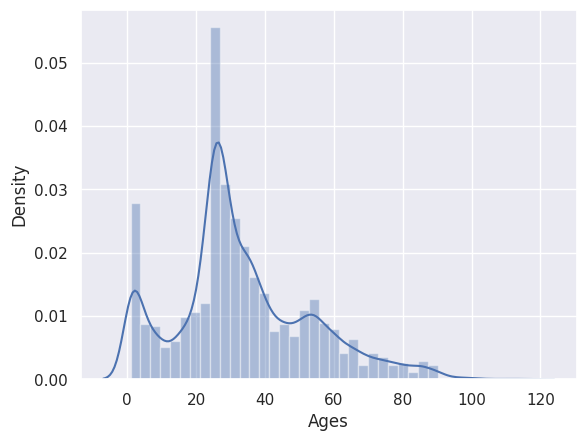

In [11]:
sns.set_theme()
sns.distplot(df_original['Ages'],kde=True, bins=40)

### Ages Classes

Text(0, 0.5, 'Counts')

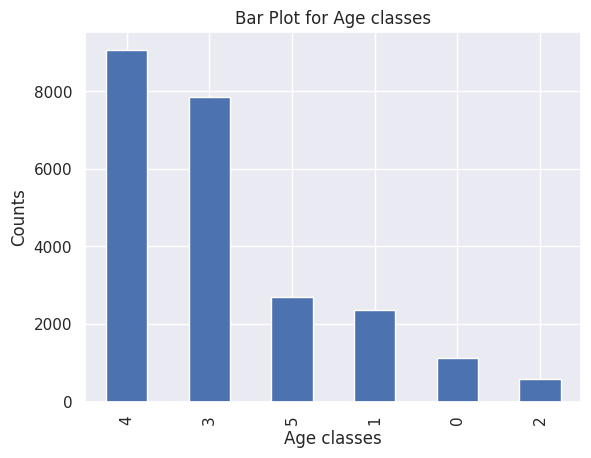

In [12]:
df_original["Age_classes"].value_counts().plot(kind='bar')

# set the title and axis labels
plt.title("Bar Plot for Age classes")
plt.xlabel("Age classes")
plt.ylabel("Counts")

In [13]:
print(df_original.Age_classes.value_counts())

4    9081
3    7862
5    2690
1    2371
0    1123
2     581
Name: Age_classes, dtype: int64


### Balanced Age Classes

In [14]:
groups = df_original.groupby('Age_classes')

# create a list to hold the sampled dataframes
sampled_dfs = []

# randomly select 581 rows from each group
for name, group in groups:
    sampled_df = group.sample(580)
    sampled_dfs.append(sampled_df)

# concatenate the sampled dataframes into a single balanced dataframe
balanced_df_age_classes = pd.concat(sampled_dfs)

# reset the index of the new dataframe
balanced_df_age_classes = balanced_df_age_classes.reset_index(drop=True)

Text(0, 0.5, 'Counts')

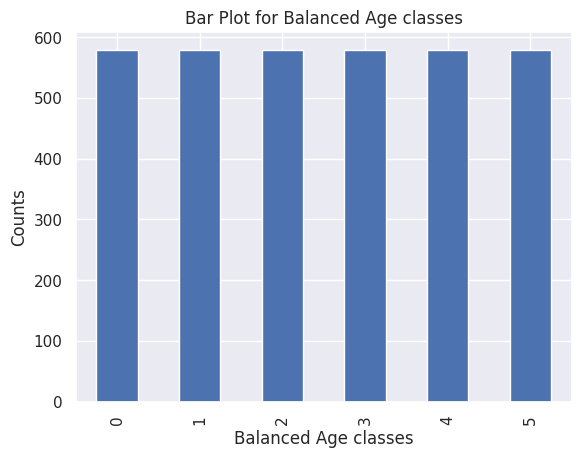

In [15]:
balanced_df_age_classes["Age_classes"].value_counts().plot(kind='bar')

# set the title and axis labels
plt.title("Bar Plot for Balanced Age classes")
plt.xlabel("Balanced Age classes")
plt.ylabel("Counts")

In [16]:
print(balanced_df_age_classes.Age_classes.value_counts())

0    580
1    580
2    580
3    580
4    580
5    580
Name: Age_classes, dtype: int64


## Gender

Text(0, 0.5, 'Counts')

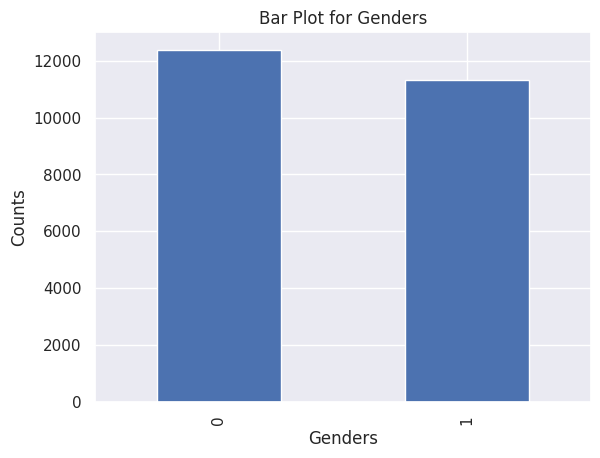

In [17]:
df_original["Genders"].value_counts().plot(kind='bar')

# set the title and axis labels
plt.title("Bar Plot for Genders")
plt.xlabel("Genders")
plt.ylabel("Counts")

## Balanced Gender

In [18]:
groups = df_original.groupby('Genders')

# create a list to hold the sampled dataframes
sampled_dfs = []

# randomly select 10000 rows from each group
for name, group in groups:
    sampled_df = group.sample(10000)
    sampled_dfs.append(sampled_df)

# concatenate the sampled dataframes into a single balanced dataframe
balanced_df_gender = pd.concat(sampled_dfs)

# reset the index of the new dataframe
balanced_df_gender = balanced_df_gender.reset_index(drop=True)

Text(0, 0.5, 'Counts')

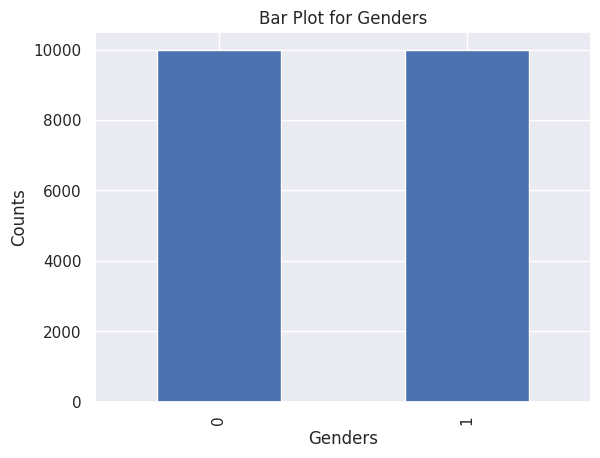

In [19]:
balanced_df_gender["Genders"].value_counts().plot(kind='bar')

# set the title and axis labels
plt.title("Bar Plot for Genders")
plt.xlabel("Genders")
plt.ylabel("Counts")

In [20]:
print(balanced_df_gender.Genders.value_counts())

0    10000
1    10000
Name: Genders, dtype: int64


# New Datasets and variables

## Balanced Age Classes


In [21]:
# Drop columns
balanced_df_age_classes = balanced_df_age_classes.drop(columns=['Ages', 'Genders'])

# shuffle the rows of the dataframe
balanced_df_age_classes = balanced_df_age_classes.sample(frac=1).reset_index(drop=True)

# reset the index of the shuffled dataframe
balanced_df_age_classes = balanced_df_age_classes.reset_index(drop=True)

# save the modified dataframe back to a csv file
#balanced_df_age_classes.to_csv("balanced_df_age_classes.csv", index=False)

## Balanced Gender

In [22]:
# Drop columns
balanced_df_gender = balanced_df_gender.drop(columns=['Ages', 'Age_classes'])

# shuffle the rows of the dataframe
balanced_df_gender = balanced_df_gender.sample(frac=1).reset_index(drop=True)

# reset the index of the shuffled dataframe
balanced_df_gender = balanced_df_gender.reset_index(drop=True)

# save the modified dataframe back to a csv file
#balanced_df_gender.to_csv("balanced_df_gender.csv", index=False)

# New X's and y's

## Age Classes

In [23]:
X_age_classes = []
y_age_classes = []

for i in range(len(balanced_df_age_classes)):
    ar = np.asarray(balanced_df_age_classes['Images'].iloc[i])
    X_age_classes.append(ar)
    agegen = int(balanced_df_age_classes['Age_classes'].iloc[i])
    y_age_classes.append(agegen)
X_age_classes = np.array(X_age_classes)

print(X_age_classes.shape)
print(len(y_age_classes))

(3480, 200, 200, 3)
3480


In [24]:
#np.savez('age_classes_vars.npz', x=X_age_classes, y=y_age_classes)

## Gender

In [25]:
X_genders = []
y_genders = []

for i in range(len(balanced_df_gender)):
    ar = np.asarray(balanced_df_gender['Images'].iloc[i])
    X_genders.append(ar)
    agegen = int(balanced_df_gender['Genders'].iloc[i])
    y_genders.append(agegen)
X_genders = np.array(X_genders)

print(X_genders.shape)
print(len(y_genders))

(20000, 200, 200, 3)
20000


In [26]:
#np.savez('gender_vars.npz', x=X_genders, y=y_genders)